### Language Translation using Encoder Decoder RNNs

Its based on this paper ["Sequence to Sequence Learning with Neural Networks" by Ilya Sutskever](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
# Create device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

## Preprocessing dataset

English-Italian dataset from Kaggle. Preprocessing is done to reduce the vocabulary and remove punctuation so that RNN can understand the patterns

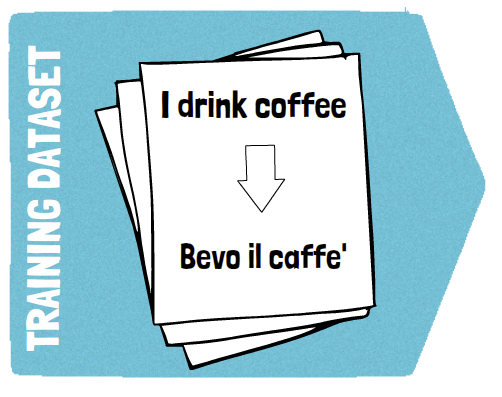

In [3]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt

--2024-11-17 03:29:00--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7240475 (6.9M) [text/plain]
Saving to: ‘eng_ita_v2.txt’

eng_ita_v2.txt      100%[===================>]   6.90M  --.-KB/s    in 0.02s   

2024-11-17 03:29:01 (280 MB/s) - ‘eng_ita_v2.txt’ saved [7240475/7240475]



In [4]:
import numpy as np
def read_data(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
  pairs = [[s for s in line.split(' -> ')] for line in lines] # Gives the sentence pairs
  return pairs

In [5]:
file_path = 'eng_ita_v2.txt'
pairs = read_data(file_path)
print(len(pairs))
print(pairs[:20])

120746
[['hi', 'ciao'], ['run', 'corri'], ['who', 'chi'], ['wow', 'wow'], ['jump', 'salta'], ['stop', 'fermati'], ['wait', 'aspetta'], ['do it', 'fallo'], ['go on', 'vai avanti'], ['hello', 'buongiorno'], ['i ran', 'ho corso'], ['i see', 'capisco'], ['i try', 'provo'], ['i won', 'ho vinto'], ['oh no', 'oh no'], ['relax', 'rilassati'], ['shoot', 'spara'], ['smile', 'sorridi'], ['ask me', 'chiedimi'], ['attack', 'attacca']]


## Tokenization

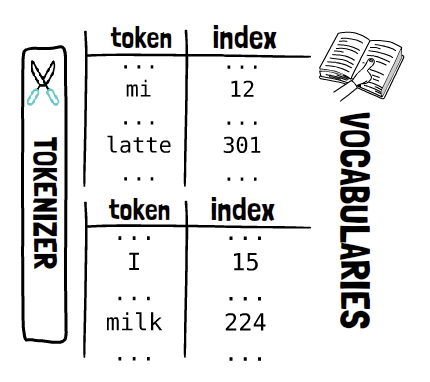

In [6]:
def tokenize(sentence):
  return sentence.lower().split()

# Tokenize and build the vocabulary
def build_vocab(sentence):
  eng_vocab = set()
  ita_vocab = set()
  for eng, ita in pairs:
    eng_vocab.update(tokenize(eng))
    ita_vocab.update(tokenize(ita))
  return eng_vocab, ita_vocab

english_vocab, italian_vocab = build_vocab(pairs)

# Word to index dict
eng_word2int = {word: index for index, word in enumerate(english_vocab)}
ita_word2int = {word: index for index, word in enumerate(italian_vocab)}

# Index to word dict
eng_int2word = {index: word for index, word in enumerate(english_vocab)}
ita_int2word = {index: word for index, word in enumerate(italian_vocab)}

print("English vocab size: ", len(eng_word2int))
print("Italian vocab size: ", len(ita_word2int))


English vocab size:  4997
Italian vocab size:  13673


In [7]:
# Example usage
eng_example = "Who are you"
ita_example = "chi sei tu"

# Encoding
eng_encoded = [eng_word2int[word] for word in tokenize(eng_example)]
ita_encoded = [ita_word2int[word] for word in tokenize(ita_example)]

print("English encoded: ", eng_encoded)
print("Italian encoded: ", ita_encoded)

# Decoding
print("English decoded: ", " ".join([eng_int2word[index] for index in eng_encoded]))
print("Italian decoded: ", " ".join([ita_int2word[index] for index in ita_encoded]))

English encoded:  [2758, 4758, 2568]
Italian encoded:  [2458, 12638, 11365]
English decoded:  who are you
Italian decoded:  chi sei tu


## Dataset and Dataloaders

Special Tokens need to be added to the dataset.
- **PAD_TOKEN** (<PAD>): This token is used for padding shorter sequences to match the length of the longest sequence in a batch. Padding ensures that all sequences in a batch have the same length, which is a requirement for many models.

- **EOS_TOKEN** (<EOS>): The End Of Sequence/Sentence token signifies the end of a sequence. This is particularly important in models that generate text, as it indicates when the model should stop generating further output.

- **SOS_TOKEN** (<SOS>): The Start Of Sequence/Sentence token is used to signal the beginning of a new sequence. This is often used in models that generate sequences, as it indicates the start of a new textual output.

- **UNK_TOKEN** (<UNK>): The Unknown token is used to represent words that are not in the vocabulary. This is a common practice in NLP applications to handle rare or unknown words that the model may encounter.

In [8]:
# Special Tokens
PAD_TOKEN = "<PAD>"
EOS_TOKEN = "<EOS>"
SOS_TOKEN = "<SOS>"
UNK_TOKEN = "<UNK>"

# Update the function to create mappings to include the special tokens
def create_mappings(vocab):
  vocab = [PAD_TOKEN, EOS_TOKEN, SOS_TOKEN, UNK_TOKEN] + sorted(vocab)
  word2int = {word: index for index, word in enumerate(vocab)}
  int2word = {index: word for index, word in enumerate(vocab)}
  return word2int, int2word

# Update both the vocabularies with new special tokens
eng_word2int, eng_int2word = create_mappings(english_vocab)
ita_word2int, ita_int2word = create_mappings(italian_vocab)

In [9]:
class TranslationDataset(Dataset):
  def __init__(self, pairs, eng_word2int, ita_word2int):
    self.pairs = pairs
    self.eng_word2int = eng_word2int
    self.ita_word2int = ita_word2int

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, index):
    eng_sentence, ita_sentence = self.pairs[index]
    eng_tensor = torch.tensor([self.eng_word2int[word] for word in tokenize(eng_sentence)]+[self.eng_word2int[EOS_TOKEN]], dtype=torch.long)
    ita_tensor = torch.tensor([self.ita_word2int[word] for word in tokenize(ita_sentence)]+[self.ita_word2int[EOS_TOKEN]], dtype=torch.long)
    return eng_tensor, ita_tensor

# Handle padding since in a batch len of tokens might differ for different sentence and while parallely training we have to have rectrangular tensor
def collate_fn(batch):
  eng_batch, ita_batch = zip(*batch)
  eng_batch_padded = pad_sequence(eng_batch, batch_first=True, padding_value=eng_word2int[PAD_TOKEN])
  ita_batch_padded = pad_sequence(ita_batch, batch_first=True, padding_value=ita_word2int[PAD_TOKEN])
  return eng_batch_padded, ita_batch_padded

In [10]:
from torch.nn.utils.rnn import pad_sequence

# Create the dataset and dataloader
translation_dataset = TranslationDataset(pairs, eng_word2int, ita_word2int)
batch_size = 64
translation_dataloader = DataLoader(translation_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn) # Collate function helps you define more complex operation on your batch

print("Translation samples: ", len(translation_dataset))
print("Translation batches: ", len(translation_dataloader))

Translation samples:  120746
Translation batches:  1886


In [11]:
for eng, ita in translation_dataloader:
  print("English batch: ",eng, eng.shape)
  print("Italian batch: ",ita, ita.shape)
  break # Look at 1st element

English batch:  tensor([[4985, 2551, 4715,  ...,    0,    0,    0],
        [4402,  253, 2992,  ...,    0,    0,    0],
        [2308, 4207, 4114,  ...,    0,    0,    0],
        ...,
        [2146, 1350, 2197,  ...,    0,    0,    0],
        [4808, 3865, 2557,  ...,    0,    0,    0],
        [4478, 4475, 2652,  ...,    0,    0,    0]]) torch.Size([64, 32])
Italian batch:  tensor([[11178,  7340, 12011,  ...,     0,     0,     0],
        [ 2474, 11583,   561,  ...,     0,     0,     0],
        [ 5869,  5808,    40,  ...,     0,     0,     0],
        ...,
        [11537,  5813,  5106,  ...,     0,     0,     0],
        [ 7628,  4235, 10962,  ...,     0,     0,     0],
        [12656,  7217,  5580,  ...,     0,     0,     0]]) torch.Size([64, 32])


## Encoder Decoder RNN

- **Encoder**: the first RNN component processes the input sentence and converts it into a fixed-size hidden representation.


- **Decoder**: the second RNN component takes the hidden representation from the encoder and produces the translated sentence in the target language.


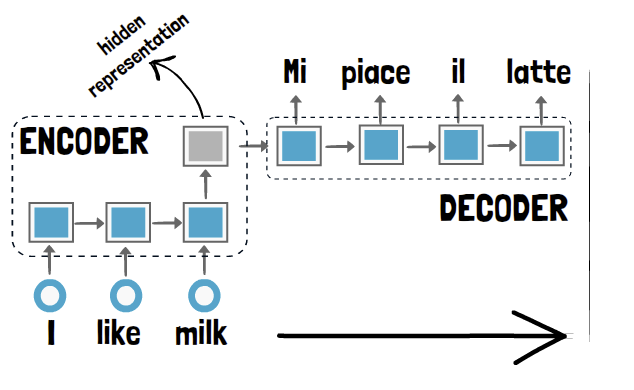

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers=1):
    super().__init__()
    self.hid_dim = hid_dim
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True)

  def forward(self, x):
     # Reversing the sequence of indices meaning feeding the sequence backwards
     x = torch.flip(x, [1])
     embedded = self.embedding(x)
     output, (hidden, cell) = self.rnn(embedded)
     return output, hidden, cell

In [13]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers=1):
    super().__init__()
    self.hid_dim = hid_dim
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True)
    self.fc = nn.Linear(hid_dim, vocab_size)

  def forward(self, x, hidden, cell):
    embedded = self.embedding(x)
    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    prediction = self.fc(output).reshape(output.size(0), -1) # Rehsape to (batch, seq_len*vocab)
    return prediction, hidden, cell

In [14]:
# Hyperparamters
eng_vocab_size = len(eng_word2int)
ita_vocab_size = len(ita_word2int)
embed_size = 256
hidden_size = 512
num_layers = 1

# Initialize the model
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)

## Inference

Both the encoder and decoder RNNs will take in a sequence of tokens and project them into embeddings. When it comes to the encoder, we discard the outputs at the individual time steps and only consider the last hidden state which we feed into the decoder. The decoder works in the same way as a regular language model, predicting the Italian translation one word at a time.

As for our basic language model, the decoder typically has a linear layer at the end that outputs the logits which give us the probability distribution across the Italian vocabulary of the next word. The only difference with a regular language model is that we use a special SOS as the seed for the first time step. We continue generating words until the model outputs another special token called the “EOS” (end of sentence).

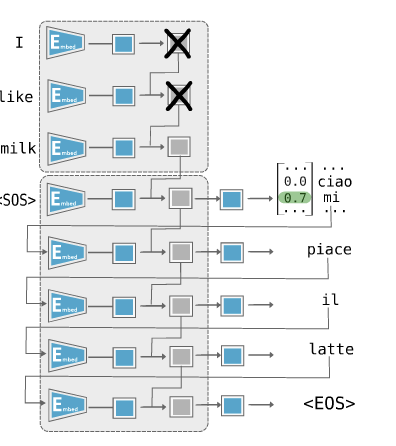

In [15]:
def translate(encoder, decoder, sentence, eng_word2int, ita_int2word, max_length=15):
  encoder.eval()
  decoder.eval()
  with torch.inference_mode():
    # Tokenize and encode the sentence
    input_tensor = torch.tensor([eng_word2int[word] for word in tokenize(sentence)] + [eng_word2int[EOS_TOKEN]], dtype=torch.long)
    input_tensor = input_tensor.view(1,-1).to(DEVICE) # batch_first=True
    # Encoder
    _, encoder_hidden, encoder_cell = encoder(input_tensor)
    # Initialize the decoder input with SOS token
    decoder_input = torch.tensor([[eng_word2int[SOS_TOKEN]]], dtype=torch.long).to(DEVICE)
    # Initialize the decoder hidden state with the encoder hidden state
    decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

    # Decoding the sentence
    decoded_words = []
    last_word = torch.tensor([[eng_word2int[SOS_TOKEN]]]).to(DEVICE)
    for _ in range(max_length):
      logits, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
      next_token = logits.argmax(dim=1) #greedy
      last_word = torch.tensor([[next_token]]).to(DEVICE)
      if next_token.item() == ita_word2int[EOS_TOKEN]:
        break
      else:
        decoded_words.append(ita_int2word[next_token.item()])
      decoder_input = last_word
    return ' '.join(decoded_words)

In [18]:
# Example inference with Enc-Dec RNN
sentence = "how are you tom"
translated_sentence = translate(encoder, decoder, sentence, eng_word2int, ita_int2word)
print(f"Original Sentence: {sentence}")
print(f"Translated Sentence: {translated_sentence}")

Original Sentence: how are you tom
Translated Sentence: come sei tom


## Training

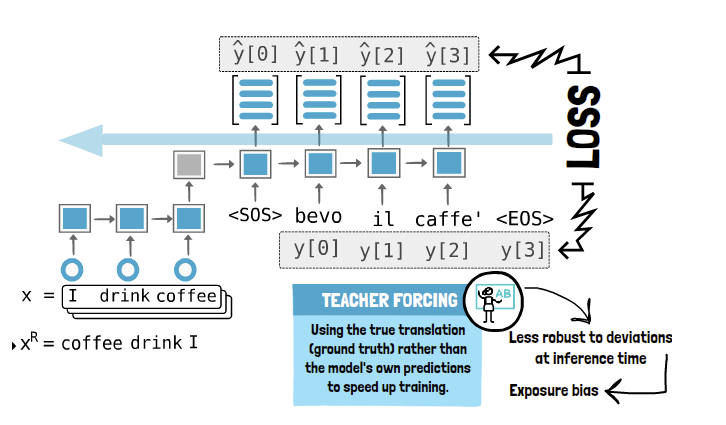

In [17]:
import torch.optim as optim
import torch.nn as nn
import random

# Loss function exclusing padding
loss_fn = nn.CrossEntropyLoss(ignore_index=eng_word2int[PAD_TOKEN])

# Optimizers
encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())

# Number of epochs
num_epochs = 10

# Training Loop
encoder.train()
decoder.train()

for epoch in range(num_epochs):
  for i, (input_tensor, target_tensor) in enumerate(translation_dataloader):
    input_tensor, target_tensor = input_tensor.to(DEVICE), target_tensor.to(DEVICE)
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(1)
    # Encoder pass
    _, encoder_hidden, encoder_cell = encoder(input_tensor)

    # Decoder pass
    decoder_input = torch.full((batch_size, 1), eng_word2int[SOS_TOKEN], dtype=torch.long).to(DEVICE)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    loss = 0

    for w in range(target_length):
      logits, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
      loss += loss_fn(logits, target_tensor[:, w])
      decoder_input = target_tensor[:, w].reshape(batch_size, 1) # Teacher forcing

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    if i%100 ==0:
      print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()/target_length:.4f}")

Epoch: 0, Batch: 0, Loss: 9.5295
Epoch: 0, Batch: 100, Loss: 5.3840
Epoch: 0, Batch: 200, Loss: 4.1801
Epoch: 0, Batch: 300, Loss: 3.7313
Epoch: 0, Batch: 400, Loss: 4.0424
Epoch: 0, Batch: 500, Loss: 4.1830
Epoch: 0, Batch: 600, Loss: 3.5936
Epoch: 0, Batch: 700, Loss: 3.1467
Epoch: 0, Batch: 800, Loss: 2.8588
Epoch: 0, Batch: 900, Loss: 3.5397
Epoch: 0, Batch: 1000, Loss: 2.8409
Epoch: 0, Batch: 1100, Loss: 3.1560
Epoch: 0, Batch: 1200, Loss: 3.4706
Epoch: 0, Batch: 1300, Loss: 2.6356
Epoch: 0, Batch: 1400, Loss: 2.5735
Epoch: 0, Batch: 1500, Loss: 2.8568
Epoch: 0, Batch: 1600, Loss: 2.0130
Epoch: 0, Batch: 1700, Loss: 2.0522
Epoch: 0, Batch: 1800, Loss: 2.8315
Epoch: 1, Batch: 0, Loss: 2.0597
Epoch: 1, Batch: 100, Loss: 1.5840
Epoch: 1, Batch: 200, Loss: 2.2283
Epoch: 1, Batch: 300, Loss: 1.7867
Epoch: 1, Batch: 400, Loss: 1.4444
Epoch: 1, Batch: 500, Loss: 2.3313
Epoch: 1, Batch: 600, Loss: 1.7416
Epoch: 1, Batch: 700, Loss: 1.8438
Epoch: 1, Batch: 800, Loss: 1.5845
Epoch: 1, Batch

## Bidirectional RNN

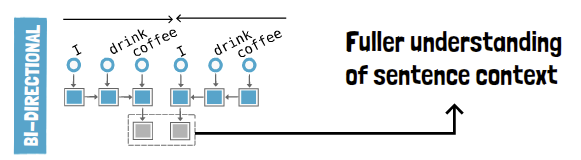

### Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Encoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers=1):
    super().__init__()
    self.hid_dim = hid_dim
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, bidirectional=True)

  def forward(self, x):
     embedded = self.embedding(x)
     output, (hidden, cell) = self.rnn(embedded)
     # Concatenate hidden states of bidirectional RNN layer
     hidden = torch.cat((hidden[0, :, :], hidden[1, :, :]), dim=1).unsqueeze(0)
     cell = torch.cat((cell[0, :, :], cell[1, :, :]), dim=1).unsqueeze(0)

     return output, hidden, cell

class Decoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers=1):
    super().__init__()
    self.hid_dim = hid_dim
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True)
    self.fc = nn.Linear(hid_dim, vocab_size)

  def forward(self, x, hidden, cell):
    embedded = self.embedding(x)
    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    prediction = self.fc(output).reshape(output.size(0), -1) # Rehsape to (batch, seq_len*vocab)
    return prediction, hidden, cell

In [20]:
# Hyperparameters
eng_vocab_size = len(eng_word2int)
ita_vocab_size = len(ita_word2int)
embed_size = 256
hidden_size = 512
num_layers = 1

# Initialize the models
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size*2, num_layers).to(DEVICE)

### Training

In [21]:
import torch.optim as optim
import torch.nn as nn
import random

# Loss function exclusing padding
loss_fn = nn.CrossEntropyLoss(ignore_index=eng_word2int[PAD_TOKEN])

# Optimizers
encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())

# Number of epochs
num_epochs = 10

# Training Loop
encoder.train()
decoder.train()

for epoch in range(num_epochs):
  for i, (input_tensor, target_tensor) in enumerate(translation_dataloader):
    input_tensor, target_tensor = input_tensor.to(DEVICE), target_tensor.to(DEVICE)
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(1)
    # Encoder pass
    _, encoder_hidden, encoder_cell = encoder(input_tensor)

    # Decoder pass
    decoder_input = torch.full((batch_size, 1), eng_word2int[SOS_TOKEN], dtype=torch.long).to(DEVICE)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    loss = 0

    for w in range(target_length):
      logits, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
      loss += loss_fn(logits, target_tensor[:, w])
      decoder_input = target_tensor[:, w].reshape(batch_size, 1) # Teacher forcing

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    if i%100 ==0:
      print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()/target_length:.4f}")

Epoch: 0, Batch: 0, Loss: 9.5193
Epoch: 0, Batch: 100, Loss: 4.5240
Epoch: 0, Batch: 200, Loss: 3.6272
Epoch: 0, Batch: 300, Loss: 3.7755
Epoch: 0, Batch: 400, Loss: 4.0542
Epoch: 0, Batch: 500, Loss: 2.7063
Epoch: 0, Batch: 600, Loss: 5.7478
Epoch: 0, Batch: 700, Loss: 2.8860
Epoch: 0, Batch: 800, Loss: 3.5898
Epoch: 0, Batch: 900, Loss: 3.0664
Epoch: 0, Batch: 1000, Loss: 2.5271
Epoch: 0, Batch: 1100, Loss: 2.2722
Epoch: 0, Batch: 1200, Loss: 2.4899
Epoch: 0, Batch: 1300, Loss: 2.3534
Epoch: 0, Batch: 1400, Loss: 2.6798
Epoch: 0, Batch: 1500, Loss: 1.8583
Epoch: 0, Batch: 1600, Loss: 1.5156
Epoch: 0, Batch: 1700, Loss: 2.2112
Epoch: 0, Batch: 1800, Loss: 2.8179
Epoch: 1, Batch: 0, Loss: 1.7529
Epoch: 1, Batch: 100, Loss: 1.3675
Epoch: 1, Batch: 200, Loss: 1.0954
Epoch: 1, Batch: 300, Loss: 1.1367
Epoch: 1, Batch: 400, Loss: 1.2864
Epoch: 1, Batch: 500, Loss: 1.5135
Epoch: 1, Batch: 600, Loss: 1.0540
Epoch: 1, Batch: 700, Loss: 2.1858
Epoch: 1, Batch: 800, Loss: 1.4634
Epoch: 1, Batch

### Inference

In [22]:
def translate(encoder, decoder, sentence, eng_word2int, ita_int2word, max_length=15):
  encoder.eval()
  decoder.eval()
  with torch.inference_mode():
    # Tokenize and encode the sentence
    input_tensor = torch.tensor([eng_word2int[word] for word in tokenize(sentence)] + [eng_word2int[EOS_TOKEN]], dtype=torch.long)
    input_tensor = input_tensor.view(1,-1).to(DEVICE) # batch_first=True
    # Encoder
    _, encoder_hidden, encoder_cell = encoder(input_tensor)
    # Initialize the decoder input with SOS token
    decoder_input = torch.tensor([[eng_word2int[SOS_TOKEN]]], dtype=torch.long).to(DEVICE)
    # Initialize the decoder hidden state with the encoder hidden state
    decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

    # Decoding the sentence
    decoded_words = []
    last_word = torch.tensor([[eng_word2int[SOS_TOKEN]]]).to(DEVICE)
    for _ in range(max_length):
      logits, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
      next_token = logits.argmax(dim=1) #greedy
      last_word = torch.tensor([[next_token]]).to(DEVICE)
      if next_token.item() == ita_word2int[EOS_TOKEN]:
        break
      else:
        decoded_words.append(ita_int2word[next_token.item()])
      decoder_input = last_word
    return ' '.join(decoded_words)

In [25]:
# Example inference with Bidirectional Enc-Dec RNN
sentence = "have a safe travel"
translated_sentence = translate(encoder, decoder, sentence, eng_word2int, ita_int2word)
print(f"Original Sentence: {sentence}")
print(f"Translated Sentence: {translated_sentence}")

Original Sentence: have a safe travel
Translated Sentence: ha un grande pacco


## RNN with Attention

### Model

We introduce SimpleAttention, a class implementing a basic form of attention mechanism inspired by the Bahdanau et al. paper. This attention mechanism computes a context vector by focusing on different parts of the input sequence when predicting each word of the output sequence.

The formula for Bahdanau attention is as follows:

$\text{Attention}(d_{i-1}, h_s) = v^T \tanh(W_{attn}[d_{i-1}; h_s])
$

- $h_{s}$: all the encoder hidden states
- $d_{i-1}$: hidden state of the decoder
- $W_{attn}$ , $v$: learnable weights of the attention mechanism
- $;$: concatenation

In our implementation, SimpleAttention uses linear layers to compute the attention weights, and then these weights are used to create a context vector from the encoder outputs.

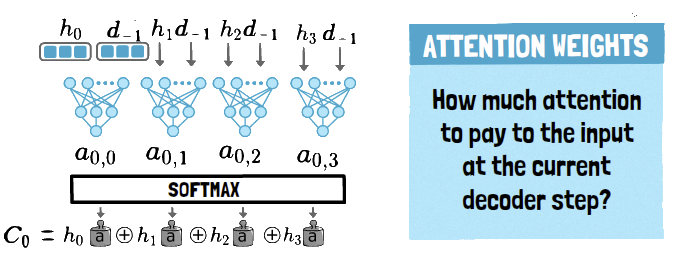

In [27]:
class SelfAttention(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.attn = nn.Linear(hidden_size*2, hidden_size*2, bias=False) # Hidden size * 2 since two hidden vector each for encoder and decoder that goes in creation of context value
    self.v = nn.Linear(hidden_size * 2, 1, bias=False)

  def forward(self, hidden, encoder_outputs):
    # Hidden: [layer*D num, batch size, hidden size]
    # encoder_outputs: [batch size, sequence length, hidden size]
    hidden = hidden.squeeze(0) # we only have 1 layer and 1 direction in decoder RNN, drop this dimension [batch size, hidden size]
    hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1) # Repeat decoder hidden state across seq length
    combined = torch.cat((hidden, encoder_outputs), dim=2) # Concatenate hidden state with encoder output
    x = torch.tanh(self.attn(combined)) # Compute the attention score
    attention = self.v(x).squeeze(2)
    attention_weights = F.softmax(attention, dim=1)
    context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1) # Compute the context as weighted sum of encoder outputs
    return context_vector, attention_weights

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn .functional as F

class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

  def forward(self, x):
    embedded = self.embedding(x)
    outputs, (hidden, cell) = self.lstm(embedded)
    # Concatenate hidden states of bidirectional RNN layers
    hidden = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1).unsqueeze(0)
    cell = torch.cat((cell[0,:,:], cell[1,:,:]), dim=1).unsqueeze(0)
    return outputs, hidden, cell

class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.attention = SelfAttention(hidden_size)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    self.attention_matrix = []

  def forward(self, x, hidden, cell, encoder_outputs, store_attention=False):
    x = self.embedding(x)
    context_vector, attention_weights = self.attention(hidden, encoder_outputs)
    if store_attention:
      self.attention_matrix.append(attention_weights.detach().cpu().numpy())
    lstm_input = torch.cat((x, context_vector.unsqueeze(1)), dim=2)
    output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
    prediction = self.fc(output).reshape(output.size(0), -1)
    return prediction, hidden, cell

  def reset_attention_matrix(self):
    self.attention_matrix = []

In [29]:
# Hyperparamters
eng_vocab_size = len(eng_word2int)
ita_vocab_size = len(ita_word2int)
embed_size = 256
hidden_size = 512
num_layers = 1

# Intialize the block
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size*2, num_layers).to(DEVICE)

### Inference

In [36]:
def translate(encoder, decoder, sentence, eng_word2int, ita_int2word, max_length=15):
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        # Tokenize and encode the sentence
        input_tensor = torch.tensor([eng_word2int[word] for word in tokenize(sentence)]
                                    + [eng_word2int[EOS_TOKEN]], dtype=torch.long)
        input_tensor = input_tensor.view(1, -1).to(DEVICE)  # batch_first=True

        # Pass the input through the encoder
        encoder_outputs, encoder_hidden, encoder_cell = encoder(input_tensor)
        # Initialize the decoder input with the SOS token
        decoder_input = torch.tensor([[eng_word2int[SOS_TOKEN]]], dtype=torch.long)  # SOS
        # Initialize the hidden state of the decoder with the encoder's hidden state
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        decoder.reset_attention_matrix()
        # Decoding the sentence
        decoded_words = []
        last_word = torch.tensor([[eng_word2int[SOS_TOKEN]]]).to(DEVICE)
        for di in range(max_length):
            logits, decoder_hidden, decoder_cell = decoder(last_word, decoder_hidden,
                                  decoder_cell, encoder_outputs, store_attention=True)
            next_token = logits.argmax(dim=1) # greedy
            last_word = torch.tensor([[next_token]]).to(DEVICE)
            if next_token.item() == ita_word2int[EOS_TOKEN]:
                break
            else:
                decoded_words.append(ita_int2word.get(next_token.item()))

        return ' '.join(decoded_words)

In [41]:
# Example usage
# s/he likes music, listening to music,
# tom likes hot chocolate
# i want to go home now
# tom likes chocolate
# tom was right about that
# tom said he would not come
# this is a fun game

sentence = "have a safe travel"
translated_sentence = translate(encoder, decoder, sentence, eng_word2int, ita_int2word)
print("Translated:", translated_sentence)

Translated: ho un uomo capace


### Training

In [33]:
import torch.optim as optim
import torch.nn as nn
import random

# Loss function exclusing padding
loss_fn = nn.CrossEntropyLoss(ignore_index=eng_word2int[PAD_TOKEN])

# Optimizers
encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())

# Number of epochs
num_epochs = 10

# Training Loop
encoder.train()
decoder.train()

for epoch in range(num_epochs):
  for i, (input_tensor, target_tensor) in enumerate(translation_dataloader):
    input_tensor, target_tensor = input_tensor.to(DEVICE), target_tensor.to(DEVICE)
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(1)
    # Encoder pass
    encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor)

    # Decoder pass
    decoder_input = torch.full((batch_size, 1), eng_word2int[SOS_TOKEN], dtype=torch.long).to(DEVICE)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    loss = 0

    for w in range(target_length):
      logits, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_output)
      loss += loss_fn(logits, target_tensor[:, w])
      decoder_input = target_tensor[:, w].reshape(batch_size, 1) # Teacher forcing

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    if i%100 ==0:
      print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()/target_length:.4f}")

Epoch: 0, Batch: 0, Loss: 9.5211
Epoch: 0, Batch: 100, Loss: 4.5261
Epoch: 0, Batch: 200, Loss: 3.7147
Epoch: 0, Batch: 300, Loss: 3.6691
Epoch: 0, Batch: 400, Loss: 3.7337
Epoch: 0, Batch: 500, Loss: 2.7086
Epoch: 0, Batch: 600, Loss: 2.9619
Epoch: 0, Batch: 700, Loss: 2.2838
Epoch: 0, Batch: 800, Loss: 2.3384
Epoch: 0, Batch: 900, Loss: 2.7531
Epoch: 0, Batch: 1000, Loss: 4.0212
Epoch: 0, Batch: 1100, Loss: 2.1844
Epoch: 0, Batch: 1200, Loss: 2.4133
Epoch: 0, Batch: 1300, Loss: 1.7609
Epoch: 0, Batch: 1400, Loss: 3.0904
Epoch: 0, Batch: 1500, Loss: 1.4948
Epoch: 0, Batch: 1600, Loss: 1.8689
Epoch: 0, Batch: 1700, Loss: 1.7010
Epoch: 0, Batch: 1800, Loss: 1.8777
Epoch: 1, Batch: 0, Loss: 1.6881
Epoch: 1, Batch: 100, Loss: 1.4026
Epoch: 1, Batch: 200, Loss: 1.6117
Epoch: 1, Batch: 300, Loss: 1.5303
Epoch: 1, Batch: 400, Loss: 2.0977
Epoch: 1, Batch: 500, Loss: 1.4651
Epoch: 1, Batch: 600, Loss: 1.0501
Epoch: 1, Batch: 700, Loss: 1.1396
Epoch: 1, Batch: 800, Loss: 1.1947
Epoch: 1, Batch

### Visualize Attention Matrix

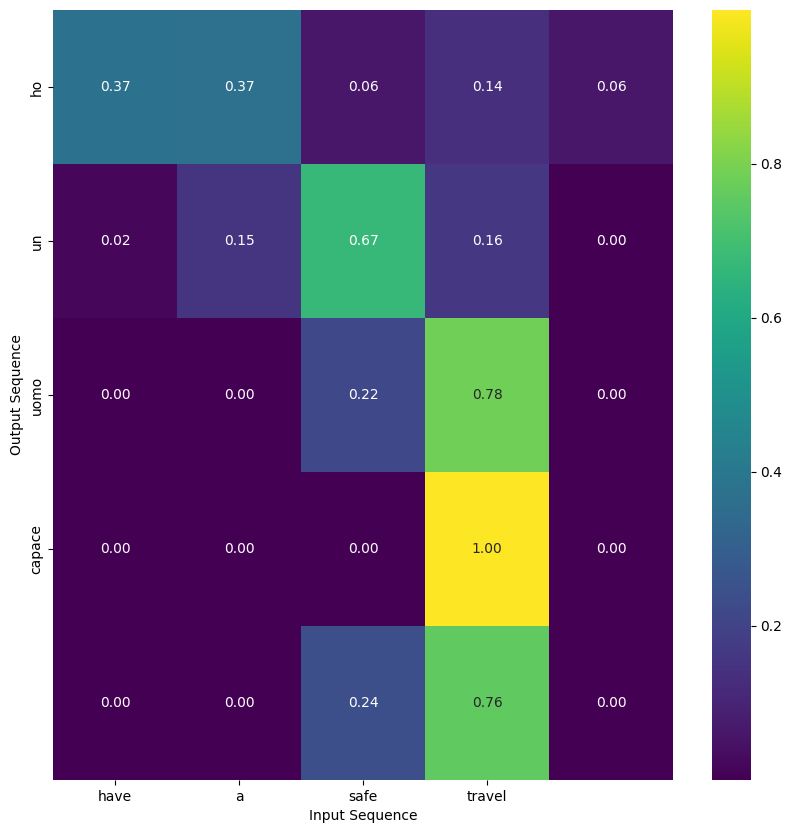

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_matrix, input_sequence, output_sequence):
  attention_matrix = attention_matrix.squeeze(1)
  fig, ax = plt.subplots(figsize=(10, 10))
  attention_heatmap = sns.heatmap(attention_matrix, annot=True, ax=ax, cmap="viridis", fmt=".2f", xticklabels=input_sequence, yticklabels=output_sequence)
  plt.xlabel('Input Sequence')
  plt.ylabel('Output Sequence')
  plt.show()

attention_matrix = np.array(decoder.attention_matrix)
plot_attention(attention_matrix, tokenize(sentence), tokenize(translated_sentence))